# GHCN Analysis

In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as pltw

from ghcn import load_daily

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://10.32.33.29:43153 Dashboard: http://10.32.33.29:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [19]:
# Get a list of all input files
# We'll sort them alphabetically to ensure reproducibility

files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_tiny/*.dly'))
# files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))
# files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))

print(len(files))
# Load in a single file to demonstrate the parser
# Just print out the first few records to illustrate the structure
load_daily(files[0])[:3][0]

50


{'station_id': 'ASN00002069',
 'year': 1993,
 'month': 7,
 'element': 'PRCP',
 'day': 1,
 'value': 0,
 'measurement': ' ',
 'quality': ' ',
 'source': 'a'}

In [20]:
%%time
# Load daily files into bags
# load_delayed = dask.delayed(load_daily)
# b = db.from_sequence(files).map(load_delayed)
# b.compute()

def value_map(d):
    return {'year':d['year'], 'value':d['value'], 'element':d['element'], 'quality':d['quality']}

# c = db.from_delayed([dask.delayed(load_daily)(fn) for fn in files])
# c = c.filter(quality_map)
# c.compute()
# c = c.map(value_map)
# c.compute()
# c = c.to_dataframe()
# c.compute()

c = db.from_delayed([dask.delayed(load_daily)(fn) for fn in files]).map(value_map).to_dataframe()
# c.compute()

# c.visualize()

CPU times: user 11.7 ms, sys: 2.9 ms, total: 14.6 ms
Wall time: 28.2 ms


In [21]:
%%time
# Compute aggregated statistics

# PRCP
# s1 = (c.filter(lambda record: record['element'] == 'PRCP')
#       .groupby(lambda record: record['year'])
#       .map(lambda record: record['value']).mean())
# s1.compute()

# prcp_res = c[c['element'] == 'PRCP'].groupby('year').value.mean().compute()
c = c[(c.value != -9999) & (c.quality == ' ')]

tmax_res = c[c['element'] == 'TMAX'].groupby('year').agg({'value':'mean'}).compute()
tmin_res = c[c['element'] == 'TMIN'].groupby('year').agg({'value':'mean'}).compute()
tavg_res = c[c['element'] == 'TAVG'].groupby('year').agg({'value':'mean'}).compute()

CPU times: user 611 ms, sys: 14 ms, total: 625 ms
Wall time: 1.27 s


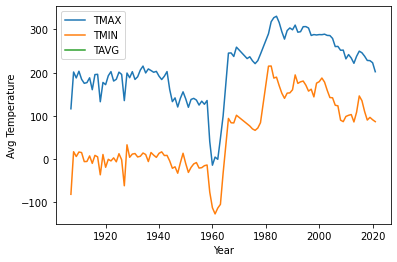

In [22]:
# Plot the results
import matplotlib.pyplot as plt

file_type = 'tiny'
tmax_res.to_csv("tmax-{}.csv".format(file_type))
tmin_res.to_csv("tmin-{}.csv".format(file_type))
tavg_res.to_csv("tavg-{}.csv".format(file_type))

tmax_res = tmax_res.sort_index()
tmin_res = tmin_res.sort_index()
tavg_res = tavg_res.sort_index()
plt.plot(tmax_res.index, tmax_res.value, label = "TMAX")
plt.plot(tmin_res.index, tmin_res.value, label = "TMIN")
plt.plot(tavg_res.index, tavg_res.value, label = "TAVG")
plt.xlabel("Year")
plt.ylabel("Avg Temperature")
plt.legend()
plt.savefig('{}.png'.format(file_type))
plt.show()